#### Display the first 10 images in train set

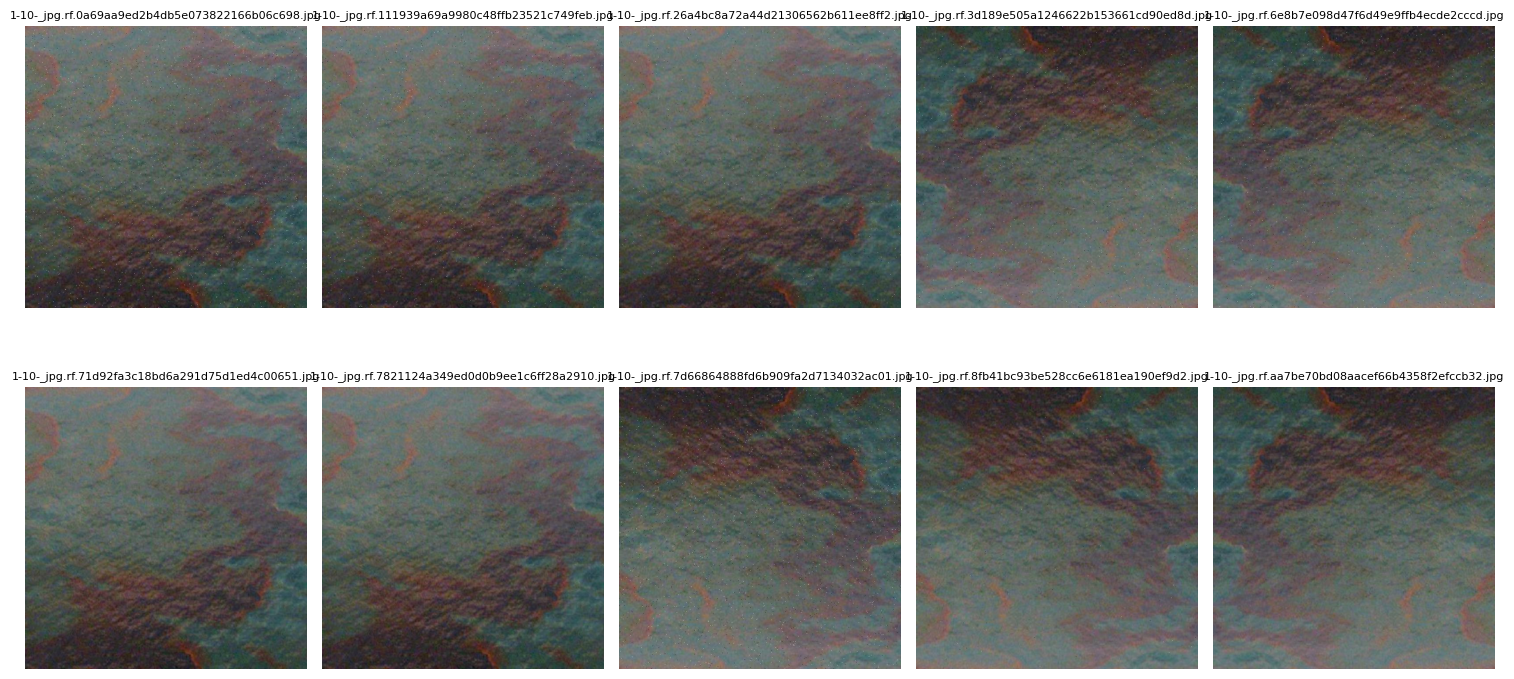

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

train_dir = os.path.join(os.getcwd(), "train\images")  



image_files = [f for f in os.listdir(train_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
image_files = sorted(image_files)[:10] 

plt.figure(figsize=(15, 8))

for i, file in enumerate(image_files):
    img_path = os.path.join(train_dir, file)
    img = cv2.imread(img_path)
    #convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(file, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


#### to save every images in same format JPG

In [2]:
import os
import cv2

BASE_DIR = os.getcwd()
splits = ["train", "valid", "test"]

def convert_images_to_jpg(split_folder):
    count = 0
    for root, dirs, files in os.walk(split_folder):
        for file in files:
            
            if file.lower().endswith((".png", ".tif", ".tiff", ".bmp", ".npy", ".jpg", ".jpeg")):
                in_path = os.path.join(root, file)
                out_path = os.path.splitext(in_path)[0] + ".jpg"

                try:
                    if file.lower().endswith((".jpg", ".jpeg")):
                      
                        print("Already JPG:", in_path)
                        count += 1
                        continue

                   
                    img = cv2.imread(in_path, cv2.IMREAD_UNCHANGED)

                    if img is None:
                        print(" not readable:", in_path)
                        continue
                    if img.dtype != "uint8":
                        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

                    # JPG
                    cv2.imwrite(out_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
                    print(" Saved:", out_path)
                    count += 1

                except Exception as e:
                    print(" Error with", in_path, ":", e)
    print(f" Total processed in {split_folder}: {count}")

# train, valid, test
for split in splits:
    folder = os.path.join(BASE_DIR, split)
    if os.path.isdir(folder):
        convert_images_to_jpg(folder)
    else:
        print(f"Folder not found: {folder}")


Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.0a69aa9ed2b4db5e073822166b06c698.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.111939a69a9980c48ffb23521c749feb.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.26a4bc8a72a44d21306562b611ee8ff2.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.3d189e505a1246622b153661cd90ed8d.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.6e8b7e098d47f6d49e9ffb4ecde2cccd.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.71d92fa3c18bd6a291d75d1ed4c00651.jpg
Already JPG: c:\Users\Lolo-\Downloads\computer-vision-project-satellite-team\train\images\1-10-_jpg.rf.7821124a349ed0d0b9ee1c6ff28a2910.jpg
Already JPG: c:\User

#### Remove empty labels and images that matched the same labels

In [3]:
import os
from collections import Counter

BASE_DIR = os.getcwd()
SPLITS = ["train", "valid", "test"]
IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp"]

CLASS_MAP = {
    "0": "object",
    "1": "rainbow",
    "2": "sheen",
    "3": "truecolor",
}

def labels_dir(split):
    cand = os.path.join(BASE_DIR, split, "labels")
    return cand if os.path.isdir(cand) else os.path.join(BASE_DIR, split)

def images_dir(split):
    cand = os.path.join(BASE_DIR, split, "images")
    return cand if os.path.isdir(cand) else os.path.join(BASE_DIR, split)

def is_empty_label_file(path):
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            if ln.strip():
                return False
    return True

def class_counts(split):
    cnt = Counter()
    lbl_dir = labels_dir(split)
    if not os.path.isdir(lbl_dir):
        return cnt
    for f in os.listdir(lbl_dir):
        if not f.endswith(".txt"):
            continue
        p = os.path.join(lbl_dir, f)
        with open(p, "r", encoding="utf-8") as fh:
            for ln in fh:
                parts = ln.strip().split()
                if not parts:
                    continue
                cid = parts[0]
                cname = CLASS_MAP.get(cid, cid)
                cnt[cname] += 1
    return cnt

def find_image_for_label(split, label_file):
    stem = os.path.splitext(label_file)[0]
    img_dir = images_dir(split)
    for ext in IMG_EXTS:
        img_path = os.path.join(img_dir, stem + ext)
        if os.path.isfile(img_path):
            return img_path
    return None

print("before deletion stats:")
for split in SPLITS:
    lbl_dir = labels_dir(split)
    empty_count, total = 0, 0
    if os.path.isdir(lbl_dir):
        for f in os.listdir(lbl_dir):
            if f.endswith(".txt"):
                total += 1
                if is_empty_label_file(os.path.join(lbl_dir, f)):
                    empty_count += 1
    print(f"{split}: empty_labels={empty_count} / total_label_files={total}")

deleted_labels = {s: 0 for s in SPLITS}
deleted_images = {s: 0 for s in SPLITS}

for split in SPLITS:
    lbl_dir = labels_dir(split)
    if not os.path.isdir(lbl_dir):
        continue
    for f in os.listdir(lbl_dir):
        if not f.endswith(".txt"):
            continue
        p = os.path.join(lbl_dir, f)
        if is_empty_label_file(p):
            os.remove(p)
            deleted_labels[split] += 1
            img_path = find_image_for_label(split, f)
            if img_path:
                os.remove(img_path)
                deleted_images[split] += 1

print("\n done deleting:")
for split in SPLITS:
    print(f"{split}: deleted_empty_labels={deleted_labels[split]}, deleted_images={deleted_images[split]}")

print("\n stats after deletion:")
for split in SPLITS:
    cnt = class_counts(split)
    print(f"{split}: {dict(cnt)}")


before deletion stats:
train: empty_labels=606 / total_label_files=1650
valid: empty_labels=43 / total_label_files=51
test: empty_labels=29 / total_label_files=119

 done deleting:
train: deleted_empty_labels=606, deleted_images=606
valid: deleted_empty_labels=43, deleted_images=43
test: deleted_empty_labels=29, deleted_images=29

 stats after deletion:
train: {'truecolor': 1158, 'sheen': 621, 'rainbow': 282, 'object': 27}
valid: {'sheen': 2, 'truecolor': 37}
test: {'sheen': 50, 'truecolor': 165, 'rainbow': 21, 'object': 1}


#### Double check to make sure no empty labels imeges 

In [5]:
import os

BASE_DIR = os.getcwd()
SPLITS = ["train", "valid", "test"]
IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp"]

def labels_dir(split):
    d = os.path.join(BASE_DIR, split, "labels")
    return d if os.path.isdir(d) else os.path.join(BASE_DIR, split)

def images_dir(split):
    d = os.path.join(BASE_DIR, split, "images")
    return d if os.path.isdir(d) else os.path.join(BASE_DIR, split)

def find_image_for_label(split, label_file):
    stem = os.path.splitext(label_file)[0]
    img_dir = images_dir(split)
    for ext in IMG_EXTS:
        cand = os.path.join(img_dir, stem + ext)
        if os.path.isfile(cand):
            return cand
    return None

for split in SPLITS:
    lbl_dir = labels_dir(split)
    any_empty = False
    leftovers = []

    if os.path.isdir(lbl_dir):
        for f in os.listdir(lbl_dir):
            if not f.endswith(".txt"):
                continue
            path = os.path.join(lbl_dir, f)
            with open(path, "r", encoding="utf-8") as fh:
                if not any(ln.strip() for ln in fh):  
                    any_empty = True
                    leftovers.append(f)

        if any_empty:
            print(f"{split}:  still found empty label files → {leftovers[:5]} ...")
        else:
            print(f"{split}:  no empty label files")

        for f in leftovers:
            img_path = find_image_for_label(split, f)
            if img_path:
                print(f"    image still exists for {f}: {img_path}")
    else:
        print(f"{split}: labels folder not found")


train:  no empty label files
valid:  no empty label files
test:  no empty label files


#### Drop "object" label

In [6]:
import os
from collections import Counter

BASE_DIR = os.getcwd()
splits = ["train", "valid", "test"]


DROP_CLASSES = {"object"}


CLASS_MAP = {
    "0": "object",
    "1": "rainbow",
    "2": "sheen",
    "3": "truecolor"
}

def count_and_list_classes(split):
    labels_dir = os.path.join(BASE_DIR, split, "labels")
    counter = Counter()
    file_classes = {}
    if not os.path.isdir(labels_dir):
        return counter, file_classes

    for file in os.listdir(labels_dir):
        if not file.endswith(".txt"): 
            continue
        path = os.path.join(labels_dir, file)
        classes_in_file = set()
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls_id = parts[0]
                cls_name = CLASS_MAP.get(cls_id, cls_id)
                counter[cls_name] += 1
                classes_in_file.add(cls_name)
        file_classes[file] = classes_in_file
    return counter, file_classes

def clean_labels(split):
    labels_dir = os.path.join(BASE_DIR, split, "labels")
    if not os.path.isdir(labels_dir):
        return 0, 0

    processed, dropped = 0, 0
    for file in os.listdir(labels_dir):
        if not file.endswith(".txt"):
            continue
        path = os.path.join(labels_dir, file)
        new_lines = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls_id = parts[0]
                cls_name = CLASS_MAP.get(cls_id, cls_id)
                if cls_name in DROP_CLASSES:  
                    dropped += 1
                    continue
                new_lines.append(line)
        with open(path, "w", encoding="utf-8") as f:
            f.writelines(new_lines)
        processed += 1
    return processed, dropped


In [7]:
# Before Dropping
print("Before Dropping")
for split in splits:
    stats, files = count_and_list_classes(split)
    print(f"\n{split.upper()}:")
    print("  Class counts:", dict(stats))
    for fname, cls in list(files.items())[:10]:  
        print(f"  {fname}: {', '.join(cls) if cls else '(empty)'}")

Before Dropping

TRAIN:
  Class counts: {'truecolor': 1158, 'sheen': 621, 'rainbow': 282, 'object': 27}
  1-10-_jpg.rf.111939a69a9980c48ffb23521c749feb.txt: truecolor
  1-10-_jpg.rf.26a4bc8a72a44d21306562b611ee8ff2.txt: truecolor
  1-10-_jpg.rf.71d92fa3c18bd6a291d75d1ed4c00651.txt: truecolor
  1-10-_jpg.rf.7d66864888fd6b909fa2d7134032ac01.txt: truecolor
  1-10-_jpg.rf.8fb41bc93be528cc6e6181ea190ef9d2.txt: truecolor
  1-10-_jpg.rf.d7e7816c7fff019338b2391ae5766dae.txt: truecolor
  1-5-_jpg.rf.015a835476c4da5e136677f6175baba3.txt: sheen
  1-5-_jpg.rf.0c6b53aac8eeb30cb3993b0927807420.txt: sheen
  1-5-_jpg.rf.1a671542086b49ad7a338ef8e843e66d.txt: sheen
  1-5-_jpg.rf.67b9d36a2ba978b0376cd2f50c0b72f5.txt: sheen

VALID:
  Class counts: {'sheen': 2, 'truecolor': 37}
  1-5-_jpg.rf.def0c8b78c7c4382f9eb1e3b421cd7bb.txt: sheen
  1001_jpg.rf.8ed5760dd02626265694374696931eb3.txt: truecolor
  1001_jpg.rf.dafa612f86977244b900188f11460ec7.txt: truecolor
  1003_jpg.rf.a341ac02944f1315091e87b3c28581b8.txt

In [9]:
# Dropping
print("\nDropping object class...")
for split in splits:
    processed, dropped = clean_labels(split)
    print(f"{split}: processed={processed}, dropped_annotations={dropped}")


Dropping object class...
train: processed=1044, dropped_annotations=0
valid: processed=8, dropped_annotations=0
test: processed=90, dropped_annotations=0


In [10]:
# After Dropping
print("\n After Dropping")
for split in splits:
    stats, files = count_and_list_classes(split)
    print(f"\n{split.upper()}:")
    print("  Class counts:", dict(stats))
    for fname, cls in list(files.items())[:10]:
        print(f"  {fname}: {', '.join(cls) if cls else '(empty)'}")


 After Dropping

TRAIN:
  Class counts: {'truecolor': 1158, 'sheen': 621, 'rainbow': 282}
  1-10-_jpg.rf.111939a69a9980c48ffb23521c749feb.txt: truecolor
  1-10-_jpg.rf.26a4bc8a72a44d21306562b611ee8ff2.txt: truecolor
  1-10-_jpg.rf.71d92fa3c18bd6a291d75d1ed4c00651.txt: truecolor
  1-10-_jpg.rf.7d66864888fd6b909fa2d7134032ac01.txt: truecolor
  1-10-_jpg.rf.8fb41bc93be528cc6e6181ea190ef9d2.txt: truecolor
  1-10-_jpg.rf.d7e7816c7fff019338b2391ae5766dae.txt: truecolor
  1-5-_jpg.rf.015a835476c4da5e136677f6175baba3.txt: sheen
  1-5-_jpg.rf.0c6b53aac8eeb30cb3993b0927807420.txt: sheen
  1-5-_jpg.rf.1a671542086b49ad7a338ef8e843e66d.txt: sheen
  1-5-_jpg.rf.67b9d36a2ba978b0376cd2f50c0b72f5.txt: sheen

VALID:
  Class counts: {'sheen': 2, 'truecolor': 37}
  1-5-_jpg.rf.def0c8b78c7c4382f9eb1e3b421cd7bb.txt: sheen
  1001_jpg.rf.8ed5760dd02626265694374696931eb3.txt: truecolor
  1001_jpg.rf.dafa612f86977244b900188f11460ec7.txt: truecolor
  1003_jpg.rf.a341ac02944f1315091e87b3c28581b8.txt: truecolor
 

#### Double check that we have only 3 classes : truecolor , sheen, rainbow

In [12]:
import os
from collections import Counter
import yaml

BASE_DIR = os.getcwd()
SPLITS = ["train", "valid", "test"]

yaml_path = os.path.join(BASE_DIR, "data.yaml")
with open(yaml_path, "r", encoding="utf-8") as f:
    data = yaml.safe_load(f)
names = data["names"]
CLASS_MAP = {str(i): name for i, name in enumerate(names)}

print("CLASS_MAP from data.yaml:", CLASS_MAP)

def labels_dir(split):
    d = os.path.join(BASE_DIR, split, "labels")
    return d if os.path.isdir(d) else os.path.join(BASE_DIR, split)

def get_class_counts(split):
    lbl_dir = labels_dir(split)
    counter = Counter()
    if not os.path.isdir(lbl_dir):
        return counter
    for f in os.listdir(lbl_dir):
        if not f.endswith(".txt"):
            continue
        path = os.path.join(lbl_dir, f)
        with open(path, "r", encoding="utf-8") as fh:
            for ln in fh:
                parts = ln.strip().split()
                if not parts:
                    continue
                cid = parts[0]
                cname = CLASS_MAP.get(cid, cid)
                counter[cname] += 1
    return counter

for split in SPLITS:
    stats = get_class_counts(split)
    if stats:
        print(f"\n{split.upper()}:")
        for cname, count in stats.items():
            print(f"  {cname}: {count}")
    else:
        print(f"\n{split.upper()}: no labels found")


CLASS_MAP from data.yaml: {'0': 'object', '1': 'rainbow', '2': 'sheen', '3': 'truecolor'}

TRAIN:
  truecolor: 1158
  sheen: 621
  rainbow: 282

VALID:
  sheen: 2
  truecolor: 37

TEST:
  sheen: 50
  truecolor: 165
  rainbow: 21


Resize all images to the same size


In [1]:
%pip install opencv-python
# Resize all images to the same size (e.g., 512x512) and save as JPG
import os
import cv2

TARGET_SIZE = (512, 512)
SPLITS = ["train", "valid", "test"]

def resize_images(split_folder, target_size):
    img_dir = os.path.join(split_folder, "images")
    if not os.path.isdir(img_dir):
        print(f"No images dir for {split_folder}")
        return
    for file in os.listdir(img_dir):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        path = os.path.join(img_dir, file)
        img = cv2.imread(path)
        if img is None:
            print(f"Cannot read: {path}")
            continue
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        # Always save as JPG
        out_path = os.path.splitext(path)[0] + ".jpg"
        cv2.imwrite(out_path, resized, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
        if out_path != path and os.path.exists(path):
            os.remove(path)  # Remove old file if format changed
        print(f"Resized and saved: {out_path}")

BASE_DIR = os.getcwd()
for split in SPLITS:
    folder = os.path.join(BASE_DIR, split)
    if os.path.isdir(folder):
        resize_images(folder, TARGET_SIZE)
    else:
        print(f"Folder not found: {folder}")

Note: you may need to restart the kernel to use updated packages.
Folder not found: c:\Users\lames\OneDrive\سطح المكتب\New folder\computer-vision-project-satellite-team\notebooks\train
Folder not found: c:\Users\lames\OneDrive\سطح المكتب\New folder\computer-vision-project-satellite-team\notebooks\valid
Folder not found: c:\Users\lames\OneDrive\سطح المكتب\New folder\computer-vision-project-satellite-team\notebooks\test
